<a href="https://colab.research.google.com/github/Neetu24/Bitcoin-Price-Prediction-/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

In [3]:
# Load dataset
df = pd.read_csv("/content/bitcoin.csv")
print(df.head())
print(df.info())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-nu

In [4]:
df.fillna(method='ffill', inplace=True)

/tmp/ipython-input-4-3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [7]:
df_scaled['SMA_20'] = df_scaled['Close'].rolling(window=20).mean()
df_scaled['EMA_20'] = df_scaled['Close'].ewm(span=20).mean()
df_scaled['Upper_BB'] = df_scaled['Close'].rolling(window=20).mean() + 2*df_scaled['Close'].rolling(window=20).std()
df_scaled['Lower_BB'] = df_scaled['Close'].rolling(window=20).mean() - 2*df_scaled['Close'].rolling(window=20).std()

# RSI Calculation
delta = df_scaled['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_scaled['RSI'] = 100 - (100 / (1 + rs))

In [8]:
df_scaled.dropna(inplace=True)
X = df_scaled.drop("Close", axis=1)
y = df_scaled["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

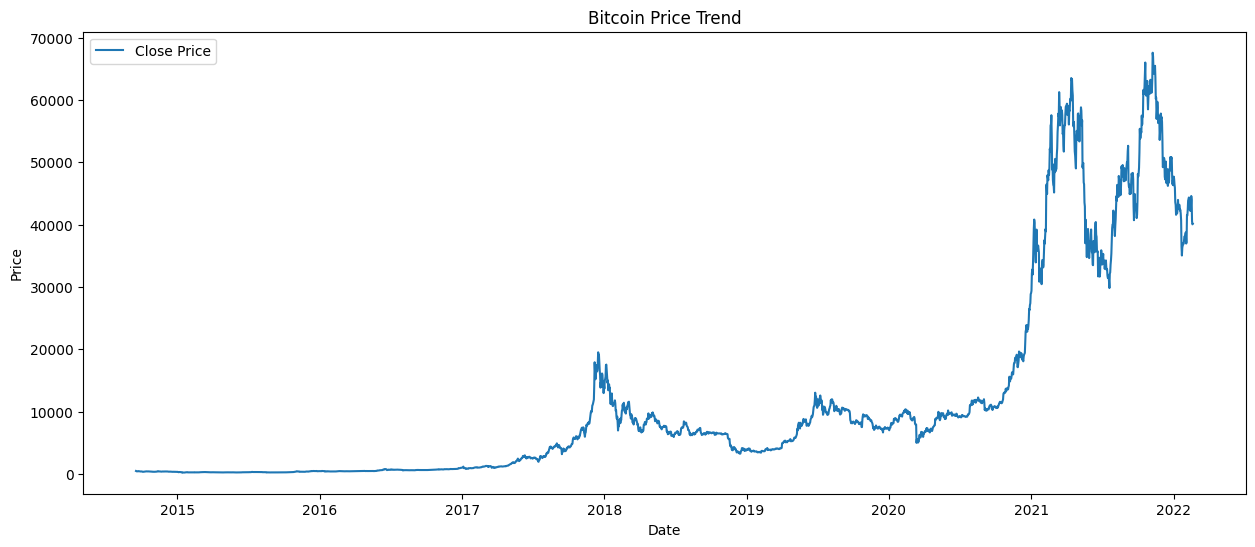

In [9]:
plt.figure(figsize=(15,6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Bitcoin Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Axes: >

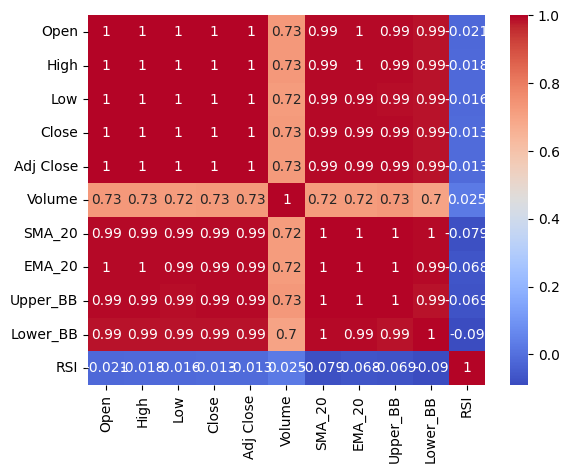

In [10]:
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm')

In [11]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(),
    "SVM": SVR(),
    "XGBoost": xgb.XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name} RMSE: {rmse:.4f}")

LinearRegression RMSE: 0.0000
RandomForest RMSE: 0.3816
SVM RMSE: 0.5162
XGBoost RMSE: 0.3987


In [12]:
best_model = xgb.XGBRegressor()
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, predictions))
print("MSE:", mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))
print("R2 Score:", r2_score(y_test, predictions))

MAE: 0.33678031079614323
MSE: 0.15894643730450425
RMSE: 0.39868087150564957
R2 Score: -1.8969994899446996
